In [309]:
%matplotlib inline

In [310]:
from IPython.display import Image
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

sns.set(style="whitegrid")

# Brandon Morrow

For this installment, we're going to build on the previous reporting notebook and start to dig into the actual "statistics" of the thing as well as do some basic modeling. 

Then, we will build a Baseline (Null) model and Distributional model, informed by your EDA and statistical inference

Variables
1. price in US dollars ($326--$18,823) (Numerical)
2. carat weight of the diamond (0.2--5.01) (Numerical)
3. cut quality of the cut (Fair, Good, Very Good, Premium, Ideal) (Categorical)
4. color diamond colour, from J (worst) to D (best) (Categorical)
5. clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)) (Categorical)
6. x length in mm (0--10.74) (Numerical)
7. y width in mm (0--58.9) (Numerical)
8. z depth in mm (0--31.8) (Numerical)
9. depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79) (Numerical)
10. table width of top of diamond relative to widest point (43--95) (Numerical)

Lets read in the dataframe and adjust out columns to match the list we have above.

In [311]:
diamonds = pd.read_csv("diamonds.csv", index_col=0)
diamonds = diamonds[["price", "carat", "cut", "color", "clarity", "x", "y", "z", "depth", "table",]]

In [312]:
diamonds.head()

,price,carat,cut,color,clarity,x,y,z,depth,table
1,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
2,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
3,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
4,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
5,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


In [313]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 non-null  float64
 2   cut      53940 non-null  object 
 3   color    53940 non-null  object 
 4   clarity  53940 non-null  object 
 5   x        53940 non-null  float64
 6   y        53940 non-null  float64
 7   z        53940 non-null  float64
 8   depth    53940 non-null  float64
 9   table    53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


Now lets handle the zero values for our model. Lets use the median as our replacement.

In [314]:
x_median = diamonds['x'].median()
y_median = diamonds['y'].median()
z_median = diamonds['z'].median()
depth_median = diamonds['depth'].median()

diamonds['x'] = diamonds['x'].replace(0, x_median)
diamonds['y'] = diamonds['y'].replace(0, y_median)
diamonds['z'] = diamonds['z'].replace(0, z_median)
diamonds['depth'] = diamonds['depth'].replace(0, z_median)

All data has been read in and we can now move on to modeling. Lets define some functions that will assist us in plotting our variables:

In [315]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

In [316]:
def plot_distribution(dataframe, variable, distribution, number_bins=0, plot_errors=False):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1, 1, 1)

    # Freeman Diaconis defined bins
    if number_bins == 0:
        h = freeman_diaconis(dataframe[variable])
        h = max(1, h)
        print("Freeman Diaconis: ", h)
        mn = int(dataframe[variable].min())
        mx = int(dataframe[variable].max())
        bins = [i for i in range( mn, mx, h)]
        axes.set_title(f"Density Histogram of {variable.capitalize()} with {distribution.capitalize()} Distribution - Freeman Diaconis = {h}")
    elif number_bins != 0:   # User defined bins
        bins = number_bins
        axes.set_title(f"Density Histogram of {variable.capitalize()} with {distribution.capitalize()} Distribution - {number_bins} Bins")

    # Plot the histogram
    n, bins, patches = axes.hist(dataframe[variable], color="DimGray", density=True, bins=bins)
    axes.set_xlabel(f"{variable.capitalize()}")

    xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    
    
    # define ys for the appropriate distribution
    if distribution.lower() == "normal" or distribution.lower() == "gaussian":
        mean = np.mean(dataframe[variable])
        std  = np.std(dataframe[variable])
        print(f"Normal: mean={mean:.2f}, std={std:.2f}")
        ys = [stats.norm.pdf( k, loc=mean, scale=std) for k in xs]
        
    elif distribution.lower() == "lognormal" or distribution.lower() == "galton":
        logged_data = np.log(dataframe[variable])
        mu = np.mean(logged_data)
        sigma = np.std(logged_data)
        print(f"Parameters of log-transformed data: mu={mu:.2f}, sigma={sigma:.2f}")
        ys = [stats.lognorm.pdf(k, s=sigma, scale=np.exp(mu)) for k in xs] # np.exp(mu) = median; using per documentation and fit
        
    elif distribution.lower() == "gamma":
        k = (np.mean(dataframe[variable])**2)/ np.var(dataframe[variable])  
        theta = np.var(dataframe[variable]) / np.mean(dataframe[variable])  
        print(f"Gamma: k={k:.2f}, theta={theta:.2f}")
        ys = [stats.gamma.pdf( x, k, loc=0, scale=theta) for x in xs]
    
    axes.plot(xs, ys, color="darkred")
    axes.set_xlabel(f"{variable.capitalize()}")
    axes.set_ylabel("Density")
    plt.show()
    plt.close()

    if plot_errors:
        plot_empirical_vs_theoretical(dataframe, variable, distribution, bins)

In [317]:
def plot_empirical_vs_theoretical(dataframe, variable, distribution, bins=None):
        
    if bins is None: # Allows function to run independent of plot function
        h = freeman_diaconis(dataframe[variable])
        h = max(1, h)
        print("Freeman Diaconis: ", h)
        mn = int(dataframe[variable].min())
        mx = int(dataframe[variable].max())
        bins = [i for i in range( mn, mx, h)]
    
    figure = plt.figure(figsize=(20, 8))

    mn = np.min(dataframe[variable])
    mx = np.max(dataframe[variable])
    mean = np.mean(dataframe[variable])
    std = np.std(dataframe[variable])

    axes = figure.add_subplot(1, 2, 1)

    values, base = np.histogram(dataframe[variable], bins=bins, density=True)
    cumulative = np.cumsum(values)
    axes.plot(base[:-1], cumulative, color="dimgray")
    axes.set_xlim((mn, mx))

    # Plot the theoretical distribution
    if distribution == "normal" or distribution == "gaussian":
        print(f"Normal: mean={mean:.2f}, std={std:.2f}")
        sampled_data = [mean + r * std for r in np.random.standard_normal(10000)]
        values2, base = np.histogram(sampled_data, bins=base, density=True)

    elif distribution == "lognormal" or distribution == "log-normal":
        logged_data = np.log(dataframe[variable])
        mu = np.mean(logged_data)
        sigma = np.std(logged_data)
        print(f"Parameters of log-transformed data: mu={mu:.2f}, sigma={sigma:.2f}")
        sampled_data = np.random.lognormal(mean=mu, sigma=sigma, size=10000)
        values2, base = np.histogram(sampled_data, bins=base, density=True)
        
    elif distribution == "gamma":
        k = mean**2 / std**2
        theta = std**2 / mean
        print(f"Gamma: k={k:.2f}, theta={theta:.2f}")
        values2, base = np.histogram(stats.gamma.rvs(k, loc=0, scale=theta, size=10000), bins=base, density=True)
    
    cumulative2 = np.cumsum(values2)
    axes.plot( base[:-1], cumulative2, color="firebrick")
    axes.set_xlim((mn, mx))
    axes.set_xlabel( f"Empirical v. Theoretical: {distribution.capitalize()} Distribution")
    axes = figure.add_subplot(1, 2, 2)

    differences = cumulative2 - cumulative
    axes.plot(base[:-1], differences, color='firebrick')
    axes.set_xlim((mn, mx))
    axes.hlines(0, 0, 14000, linestyles="dotted")
    axes.set_xlabel( f"Empirical v. Theoretical: {distribution.capitalize()} Distribution, Difference")

    plt.show()
    plt.close()

In [377]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [383]:
def plot_theta(posterior):
    figure = plt.figure(figsize=(10, 6)) 

    axes = figure.add_subplot(1, 1, 1)

    axes.hist( posterior, density=True, color="dimgray")
    axes.set_ylabel( "Density")
    axes.set_xlabel( "$\hat{theta}$")
    axes.set_title( "Posterior Distribution of $\hat{theta}$")

    plt.show()
    plt.close()

## Mathematical Distributions:
<a id="math"></a>

Now we will model mathematical distributions to our variables so that we can make predictions.

* [Price](#price)
* [Carat](#carat)
* [Cut](#cut)
* [Color](#color) 
* [Clarity](#clarity)
* [Length (x)](#length)
* [Width  (y)](#width)    
* [Depth  (z)](#depthz)
* [Depth  (%)](#depth%)
* [Table Width](#tablewidth)

<a id="price"></a>
## Predictive Model of Price
[^ table](#math)

We want to be able to predict price as in, what is the price of the next diamond we pull from the group. We want to penalize large errors more than small errors and underestimates are just as bad as overestimates. Because of this, we'll use Mean Squared Error as our loss function and we can use mean as our prediction:

In [318]:
price_prediction = diamonds.price.mean()
price_prediction

3932.799721913237

Our predicted diamond price is $3,932.80. This distributionn is not symmetric so we cannot use our typical 1.96 plus or minus for the error bounds. We need to use Chebyshev:

In [319]:
for k in range(1, 6):
    print(f"k = {k}: Percent Coverage {(1 - (1/k**2)) * 100:.2f}%")

k = 1: Percent Coverage 0.00%
k = 2: Percent Coverage 75.00%
k = 3: Percent Coverage 88.89%
k = 4: Percent Coverage 93.75%
k = 5: Percent Coverage 96.00%


In [320]:
left_bound = price_prediction - 4 * np.std(diamonds.price)
right_bound = price_prediction + 4 * np.std(diamonds.price)
print(f"Prediction = {price_prediction:.2f}({left_bound:.2f}, {right_bound:.2f})")

Prediction = 3932.80(-12024.81, 19890.41)


The value is negative so we need to model the data to a distribution.

## Price- Data Generating Story

Diamonds are created inside the earth from immense pressure and various other environmental factors that determine the carat(size) color and clarity. Once diamonds are mined they are cut to a shape that allows light to shine through the gem which is determined by the skill of the person cutting the diamond. All of these factors impact the price of a diamond. Due to the various multiplicative factors this is very likely to follow a lognormal distribution

## Price- Distributional Model

From our EDA we see that the price distribution is skewed to the right. We already have the mean and standard deviation so lets plot a lognormal distribution over 

Freeman Diaconis:  231
Parameters of log-transformed data: mu=7.79, sigma=1.01


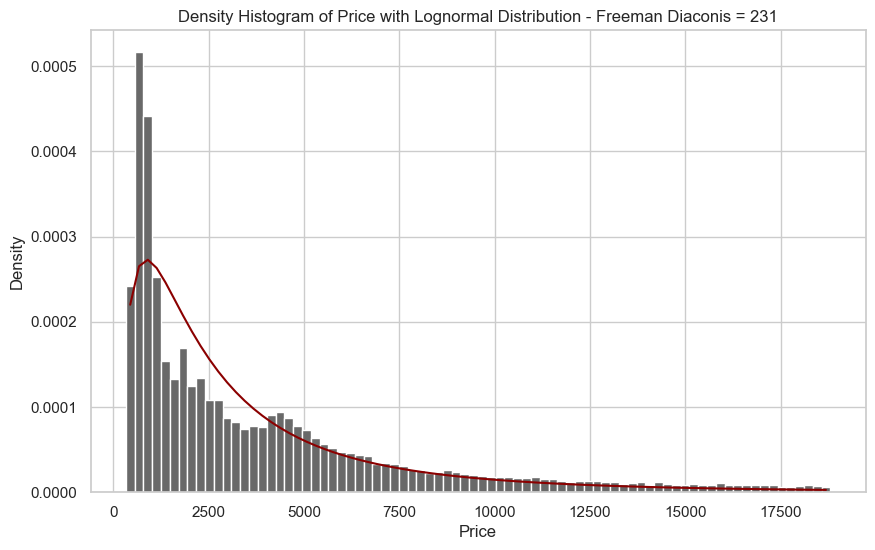

Parameters of log-transformed data: mu=7.79, sigma=1.01


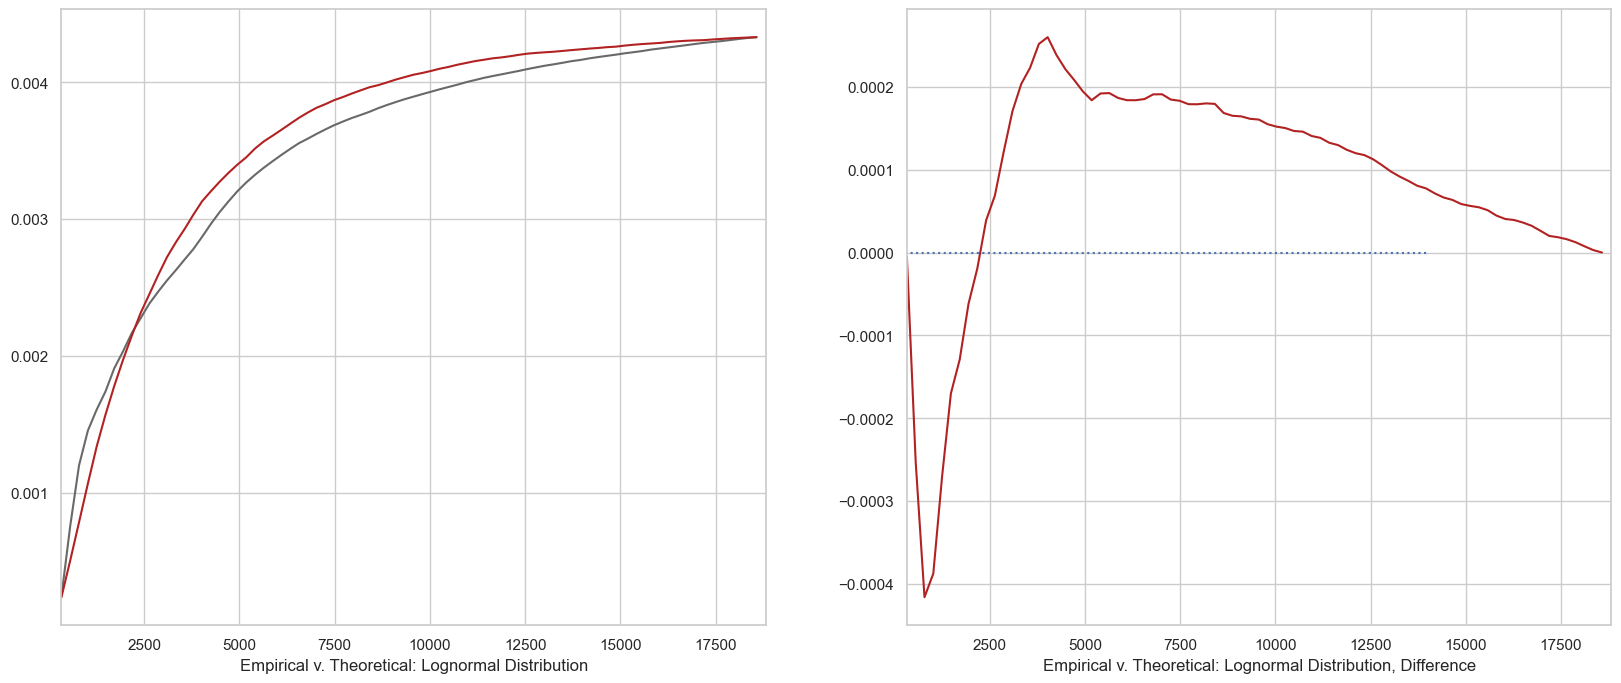

In [321]:
plot_distribution(diamonds, "price", "lognormal", plot_errors=True)

This appears to be a decent fit, and looking at our error we see that there is a discontinuity at the spike in the beginning around $1,000, and then the model slowly works back to fit our data. The model will predict fewer low price diamonds, slightly more of the middle price diamonds, and the correct price of the expensive diamonds. Now lets use our model to make some predictions.

What is the probability of observing a diamond more than $10,000?

In [322]:
logged_data = np.log(diamonds["price"])
mu = logged_data.mean()
sigma = logged_data.std()
stats.lognorm.sf(10000, s=sigma, scale=np.exp(mu))

0.08030564739105034

There is an 8.03% probability of observing a diamond greater than $10,000

What is the probability of observing a diamond between $3,000 and $8,000?

In [323]:
stats.lognorm.cdf(8000, s=sigma, scale=np.exp(mu)) - stats.lognorm.cdf(5000, s=sigma, scale=np.exp(mu))

0.11741435958269597

There is an 11.74% probability of observing a diamond from $3,000-$8,000. What is the probability of observing a diamond cheaper than $2,000?

In [324]:
stats.lognorm.cdf(2000, s=sigma, scale=np.exp(mu))

0.4273274062110797

There is a 42.73% proability of observing a diamond cheaper than $2,000

## Price- Bayesian Inference

We set a ROPE that we believe the average price for an engagement is around $4,000 give or take $100. Lets check how believable this is. 

In [379]:
theta_est = diamonds.price.mean()
theta_est

3932.799721913237

Now lets calculate our posterior.

In [382]:
posterior = bootstrap_sample(diamonds.price, np.mean)

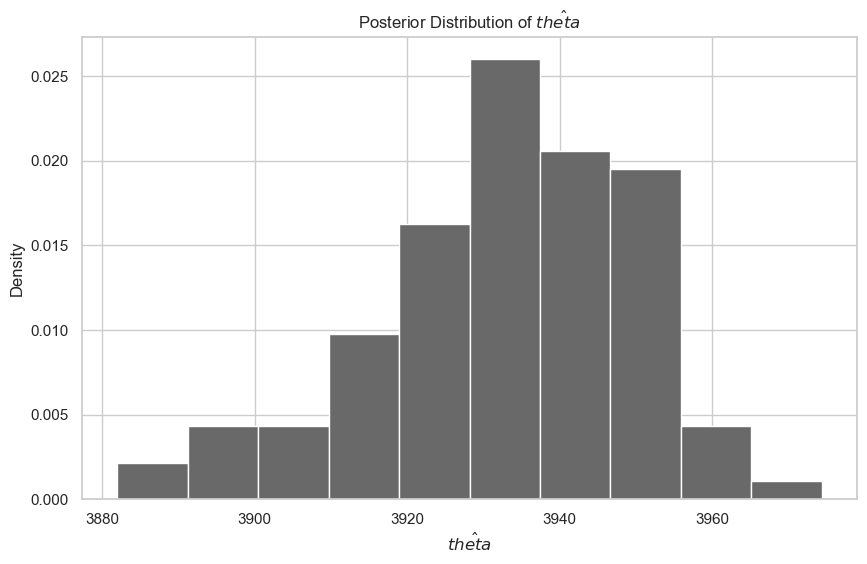

In [384]:
plot_theta(posterior)

The distribution appears normal as we would expect. Now we can get our 95% credible interval.

In [387]:
stats.mstats.mquantiles( posterior, [0.025, 0.975])

array([3892.51191834, 3962.17169698])

Now our credible interval is between $3,892 and $3,962. Lets check our ROPE for our initial assumption.

In [389]:
np.mean((posterior >= 3900) & (posterior <= 4100))

0.94

The assumption is very believable with a 94% probability of the price falling in this range. 

<a id="carat"></a>
## Predictive Model of Carat
[^ table](#math)

We want to be able to predict carat as in, what is the carat of the next diamond we pull from the group. We want to penalize large errors more than small errors and underestimates are just as bad as overestimates. Because of this, we'll use Mean Squared Error as our loss function and we can use mean as our prediction:

In [325]:
carat_prediction = np.mean(diamonds["carat"])
carat_prediction

0.7979397478680014

We predict a diamond of .80 carats. The data is not symmetric so we need to use Chebyshev's Inequality for the error bounds:

In [326]:
for k in range(1, 6):
    print(f"k = {k}: Percent Coverage {(1 - (1/k**2)) * 100:.2f}%")

k = 1: Percent Coverage 0.00%
k = 2: Percent Coverage 75.00%
k = 3: Percent Coverage 88.89%
k = 4: Percent Coverage 93.75%
k = 5: Percent Coverage 96.00%


In [327]:
left_bound = carat_prediction - 2 * np.std(diamonds.carat)
right_bound = carat_prediction + 2 * np.std(diamonds.carat)
print(f"Prediction = {carat_prediction:.2f}({left_bound:.2f}, {right_bound:.2f})")

Prediction = 0.80(-0.15, 1.75)


Even setting this to two we get a negative value. We will have to model the distribution.

## Carat- Data Generating Story

The data generating story for carats is that the size of the diamond is dependent on many different natural factors like the depth, temperature and pressure in the earth at the time of the creation of the diamond. There is also a human element once the diamond is cut. For this reason the carat data should follow a lognormal distribution.

## Carat- Distributional Model

plot

Parameters of log-transformed data: mu=-0.39, sigma=0.58


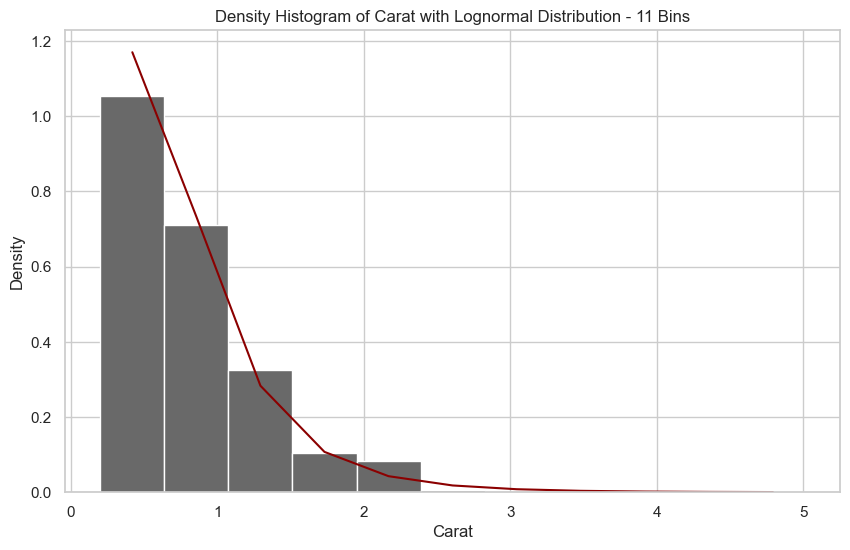

Parameters of log-transformed data: mu=-0.39, sigma=0.58


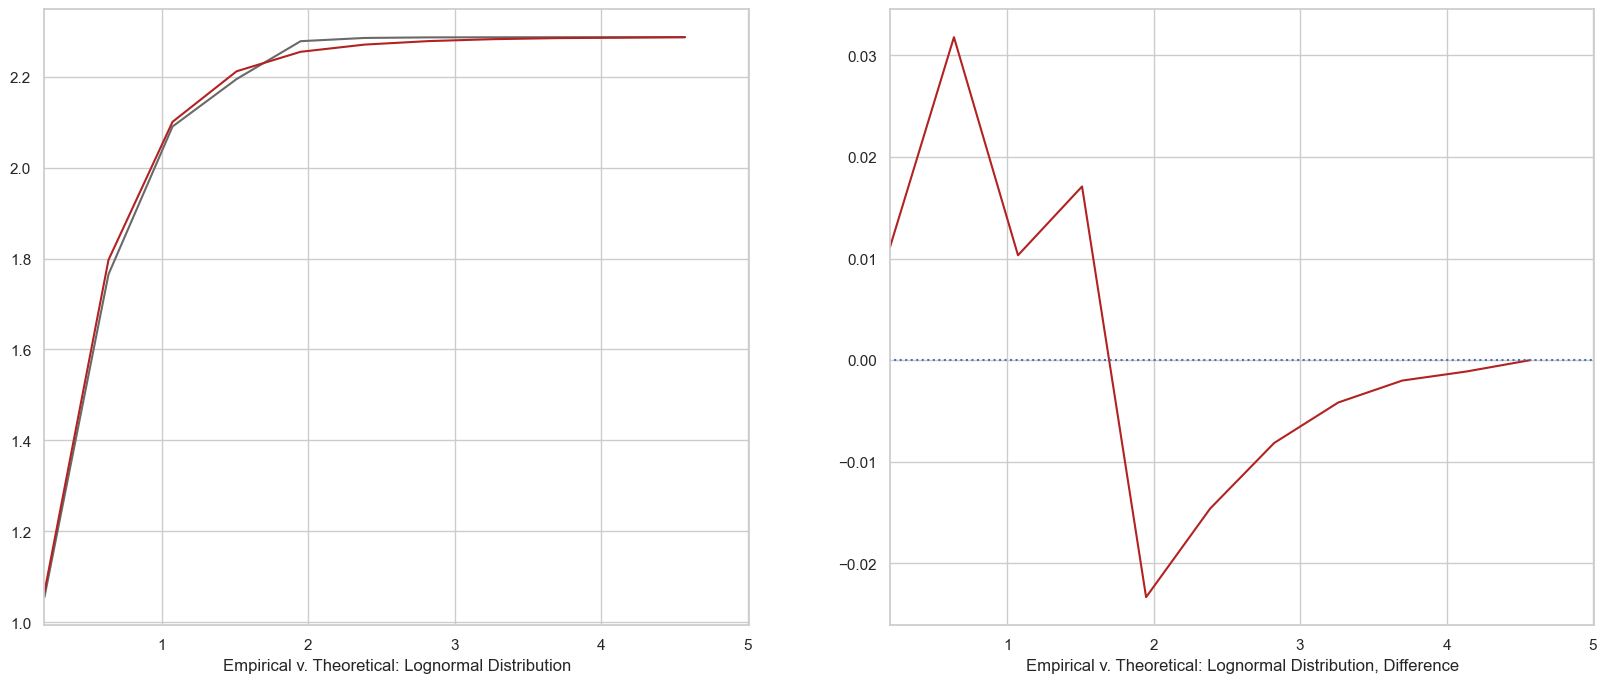

In [328]:
plot_distribution(diamonds, "carat", "lognormal", number_bins=11, plot_errors=True)

We see that this is not an ideal model, but gets decently close to a correct prediction. We see at most a .05 percentage point difference between the model and the data. Lets move to make predictions:

What is the probability that an observed diamond has more than 2 carats?

In [329]:
logged_data = np.log(diamonds["carat"])
mu = logged_data.mean()
sigma = logged_data.std()
stats.lognorm.sf(2, s=sigma, scale=np.exp(mu))

0.03140226480619306

There is a 3.14% probability of observing a random diamond and it being greater than 2 carats. What are the odds of observing a random diamond between 1 and 1.5 carats?

In [330]:
stats.lognorm.cdf(1.5, s=sigma, scale=np.exp(mu)) - stats.lognorm.cdf(1, s=sigma, scale=np.exp(mu))

0.16417245866290553

There is a 16.42% probability that a randomly observed diamond is between 1 and 1.5 carats. What is the probability of a randomly observed diamond being less than 1 carat?

In [331]:
stats.lognorm.cdf(1, s=sigma, scale=np.exp(mu)) 

0.7502753025651665

There is a 75.0% probability that the diamond is less than 1 carat.

## Bayesian Inference

We believe that the average carat should be .81 carats plus or minus one. How believable is this?


In [391]:
theta_est = diamonds.carat.mean()
theta_est

0.7979397478680014

We have our estimated theta. Now what is the posterior?

In [392]:
posterior = bootstrap_sample(diamonds.carat, np.mean)

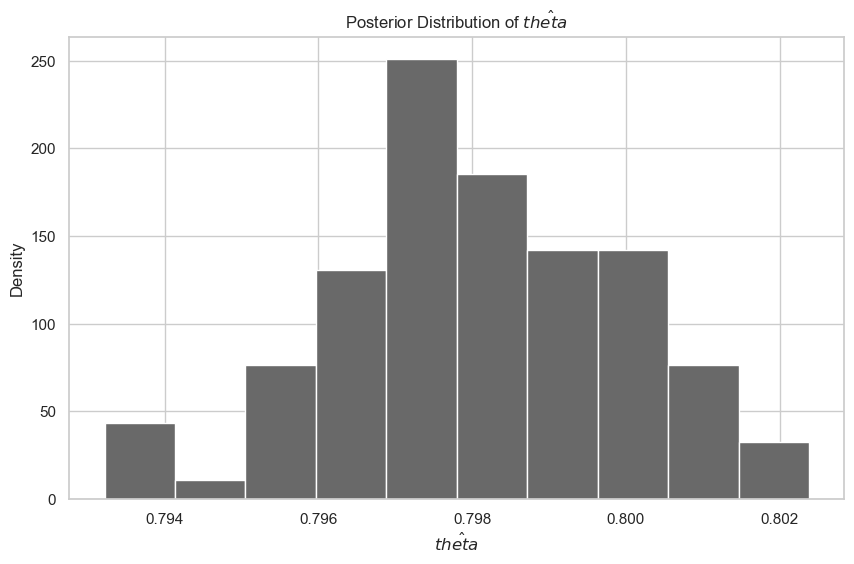

In [393]:
plot_theta(posterior)

We see the data is normally distributed lets find the credible interval and our ROPE

In [394]:
stats.mstats.mquantiles( posterior, [0.025, 0.975])

array([0.79360103, 0.80202797])

In [398]:
np.mean((posterior >= .80) & (posterior <= .82))

0.19

There is a 19% probability of a diamond carat value of 81

<a id="cut"></a>
## Predictive Model of Cut
[^ table](#math)

Since this is a categorical variable our predictions will be based on the probabilities provided by the percentage of the data. Lets find how many of each category we have. As a reminder from EDA <br> Cut from worst to best: (Fair, Good, Very Good, Premium, Ideal)

In [332]:
diamonds.cut.value_counts(normalize=True)

cut
Ideal        0.399537
Premium      0.255673
Very Good    0.223990
Good         0.090953
Fair         0.029848
Name: proportion, dtype: float64

We see that ideal has the highest probability at 39.95% followed by premium at 25.57, then Very good at 22.40%, then good at 9.1%, and then fair at 2.98%. These probabilities are in order from best/ideal diamond cut having the highest probability to worst/fair diamond cut with the lowest probability.

<Axes: title={'center': 'Cut of Diamonds Normalized'}, xlabel='cut'>

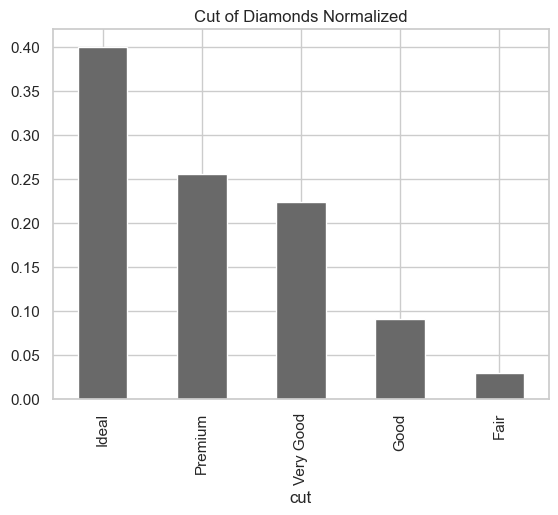

In [333]:
diamonds["cut"].value_counts(normalize=True).plot(kind="bar", title="Cut of Diamonds Normalized", color="dimgray")

21,551 (39.95%) of the diamonds are the best 'Ideal' cut grade <br>
13,791 (25.57%) of the diamonds are 'Premium' cut grade <br>
12,082 (22.40%) of the diamonds are 'Very Good' cut grade <br>
4,906 (9.10%) of the diamonds are 'Good' cut grade <br>
1,610 (2.98%) of the diamonds are 'Fair' cut grade

<a id="color"></a>
## Predictive Model of Color
[^ table](#math)

Color is a categorical variable so to get the probabilities of each color grade we will find the normalized count. As a reminder from EDA the highest grade color is colourless, and from highest to lowest grade: D-E-F-G-H-I-J with J as the worst.

In [334]:
non_normal = diamonds["color"].value_counts(normalize=False)
normal = diamonds["color"].value_counts(normalize=True)
counts = pd.DataFrame({"count": non_normal, "probability": normal})
counts['probability'] = counts['probability'].apply(lambda x: f'{(x*100):.2f}%')
display(counts.sort_index())

,count,probability
color,,
D,6775,12.56%
E,9797,18.16%
F,9542,17.69%
G,11292,20.93%
H,8304,15.39%
I,5422,10.05%
J,2808,5.21%


We see that the probabilities seem to be normally distributed around the middle possible color grade G with the probabilities decreasing as we get to the highest or lowest grade.

Text(0, 0.5, 'Counts')

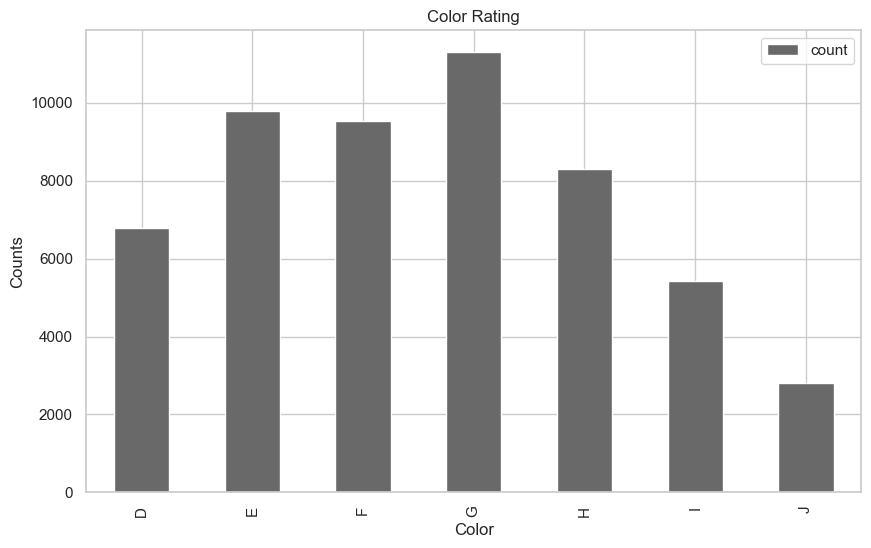

In [335]:
counts = counts.sort_index()
counts.plot(kind='bar', figsize=(10,6), title='Color Rating', color='DimGray')
plt.title('Color Rating')
plt.xlabel('Color')
plt.ylabel('Counts')

<a id="clarity"></a>
## Predictive Model of Clarity
[^ table](#math)

Clarity is a categorical variable and for this reason we will use the probabilities for each category from the data. As a reminder from EDA our clarity ranking categories: <br> I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)

In [336]:
ranks = ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"]
diamonds["clarity"] = pd.Categorical(diamonds["clarity"], ordered=True, categories=ranks)

non_normal_clarity = diamonds["clarity"].value_counts().sort_index()
normal_clarity = diamonds["clarity"].value_counts(normalize=True).sort_index()

clarity = pd.DataFrame({"count": non_normal_clarity, "probability": normal_clarity})
clarity["probability"] = clarity["probability"].apply(lambda x: f'{(x*100):.2f}%')
display(clarity)

,count,probability
clarity,,
IF,1790,3.32%
VVS1,3655,6.78%
VVS2,5066,9.39%
VS1,8171,15.15%
VS2,12258,22.73%
SI1,13065,24.22%
SI2,9194,17.04%
I1,741,1.37%


We see that the probabilities are almost normally distributed around the VS2 and SI1 grades at 22.73% and 24.22% of the data. 

<a id="length"></a>
## Predictive Model of Length (x)
[^ table](#math)

We want to be able to predict length as in, what is the length of the next diamond we pull from the group. We want to penalize large errors more than small errors and underestimates are just as bad as overestimates. Because of this, we'll use Mean Squared Error as our loss function and we can use mean as our prediction:

In [337]:
length_prediction = np.mean(diamonds.x)
length_prediction

5.732002595476454

We predict a diamond length of 5.73mm. The data appears generally symmetric so we can use the normal distribution bounds for our error bounds:

In [338]:
left_bound = length_prediction - 1.96 * np.std(diamonds.x)
right_bound = length_prediction + 1.96 * np.std(diamonds.x)
print(f"Prediction = {length_prediction:.2f}({left_bound:.2f}, {right_bound:.2f})")

Prediction = 5.73(3.54, 7.93)


We predict a length of 5.73mm with left bound of 3.53mm and right bound of 7.93mm.

## Length- Data Generating Story

The data generating story for length is extremely similar to our other data generating stories. Various environmental factors such as depth, temperature, and pressure all impacted the formation of the diamond. The crafter who cut it also impacts the dimensions of the diamonds. I believe these interactions are multiplicative so for this reason I will fit a lognormal distribution to the data.

## Length (x)- Distributional Model

Parameters of log-transformed data: mu=1.73, sigma=0.19


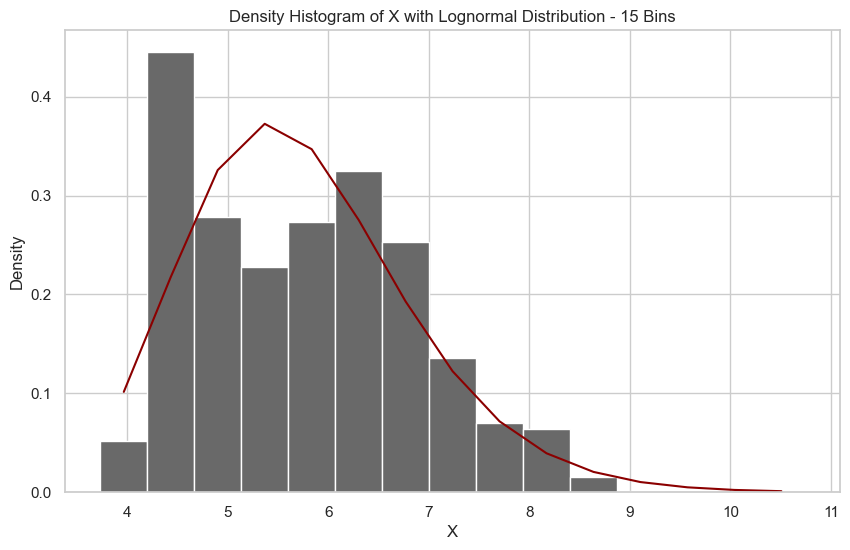

Parameters of log-transformed data: mu=1.73, sigma=0.19


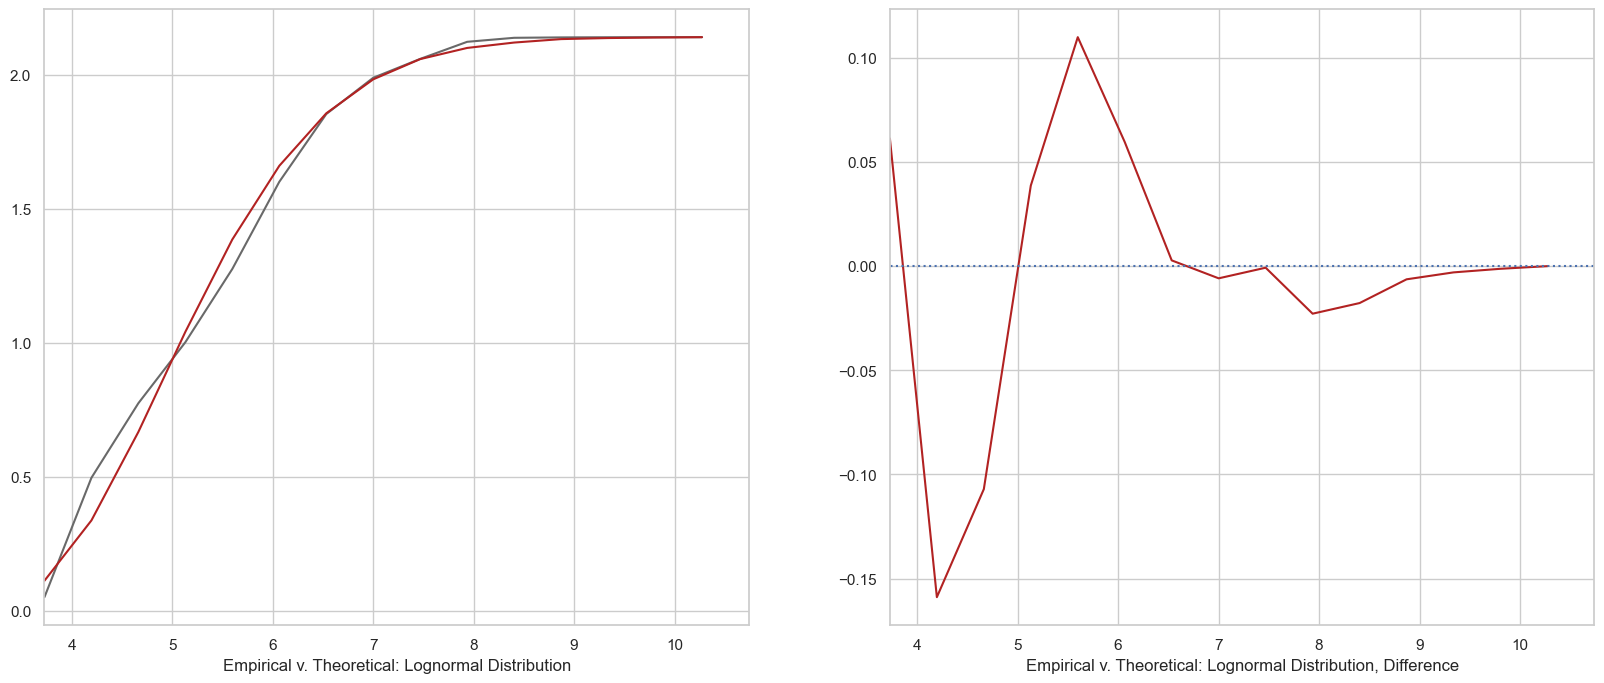

In [339]:
plot_distribution(diamonds, "x", distribution="lognormal", number_bins=15, plot_errors=True)

We see that the model is a decent fit for the length of the diamonds with the highest error at -.15 percentage points. Lets make some predictinos. What are the odds of seeing a random diamond with length greater than 8mm?

In [340]:
logged_data = np.log(diamonds["x"])
mu = logged_data.mean()
sigma = logged_data.std()
stats.lognorm.sf(8, s=sigma, scale=np.exp(mu))

0.034519466073668695

There is a 3.45% probability of observing a random diamond and its length being greater than 8mm. What are the odds of seeing a diamond between 3 and 5mm?

In [341]:
stats.lognorm.cdf(5, s=sigma, scale=np.exp(mu)) - stats.lognorm.cdf(3, s=sigma, scale=np.exp(mu))

0.2709711562658914

We see a 27.1% probability that a randomly observed diamond is between 3 and 5mm in length. What about the probability of observing a diamond that is less than 6mm?

In [342]:
stats.lognorm.cdf(6, s=sigma, scale=np.exp(mu))

0.6304632914992668

There is a 63.05% probability of observing a random diamond and it being less than 6mm in length

## Bayesian Inference

We believe that average diamond length is 5.7mm. How believable is this?

In [401]:
theta_est = diamonds.x.mean()
theta_est

5.732002595476454

In [404]:
posterior = bootstrap_sample(diamonds.x, np.mean)

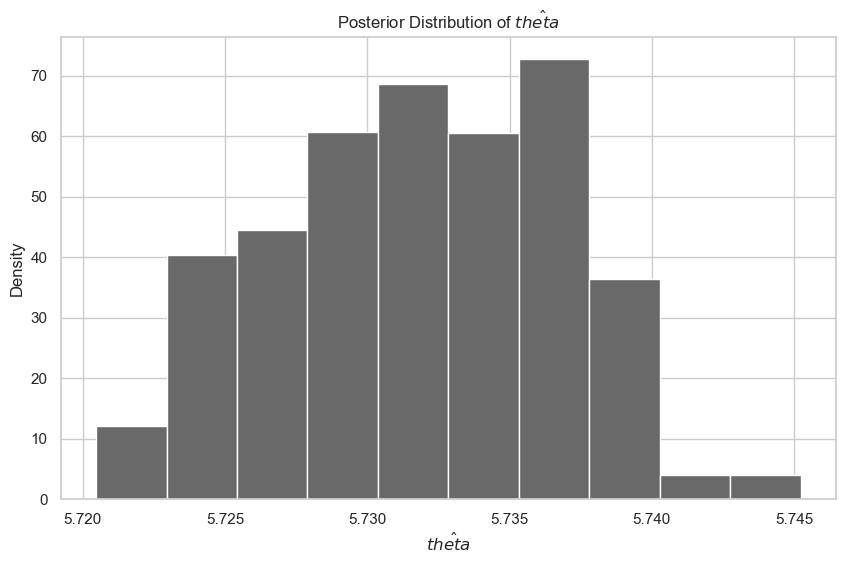

In [405]:
plot_theta(posterior)

This is normally distributed as we expect Lets predict our ROPE from before:

In [408]:
np.mean((posterior >= 5.67) & (posterior <= 5.73))

0.35

There is a 35% probability of the diamond width being between 5.67 and 5.73. This is not very believable. 

<a id="width"></a>
## Predictive Model of Width (y)
[^ table](#math)

We want to be able to predict width as in, what is the width of the next diamond we pull from the group. We want to penalize large errors more than small errors and underestimates are just as bad as overestimates. Because of this, we'll use Mean Squared Error as our loss function and we can use mean as our prediction:

In [343]:
width_prediction = np.mean(diamonds["y"])
width_prediction

5.735266963292547

We predict a diamond to have width of 5.74mm. This distribution is generally symmetric so we can use normal bounds for our error bounds:

In [344]:
left_bound = width_prediction - 1.96 * np.std(diamonds.y)
right_bound = width_prediction + 1.96 * np.std(diamonds.y)
print(f"Prediction = {width_prediction:.2f}({left_bound:.2f}, {right_bound:.2f})")

Prediction = 5.74(3.50, 7.97)


We predict a width of 5.74 with left bound of 3.50 and right bound of 7.97.

## Width (y)- Data Generating Story

The data generating story for width is the same as the data generating story for length. Various environmental factors such as depth, temperature, and pressure all impacted the formation of the diamond. The diamond crafter who cut it also impacts the dimensions of the diamonds. I believe these interactions are multiplicative so for this reason I will fit a lognormal distribution to the data.

## Width (y)- Distributional Model

Now lets plot our lognormal distribution to see how the fit is.

Freeman Diaconis:  1
Parameters of log-transformed data: mu=1.73, sigma=0.19


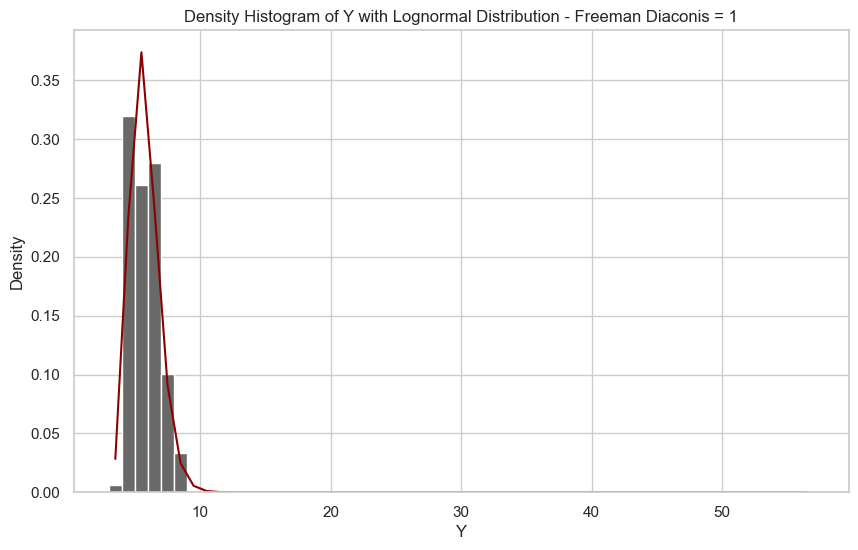

Parameters of log-transformed data: mu=1.73, sigma=0.19


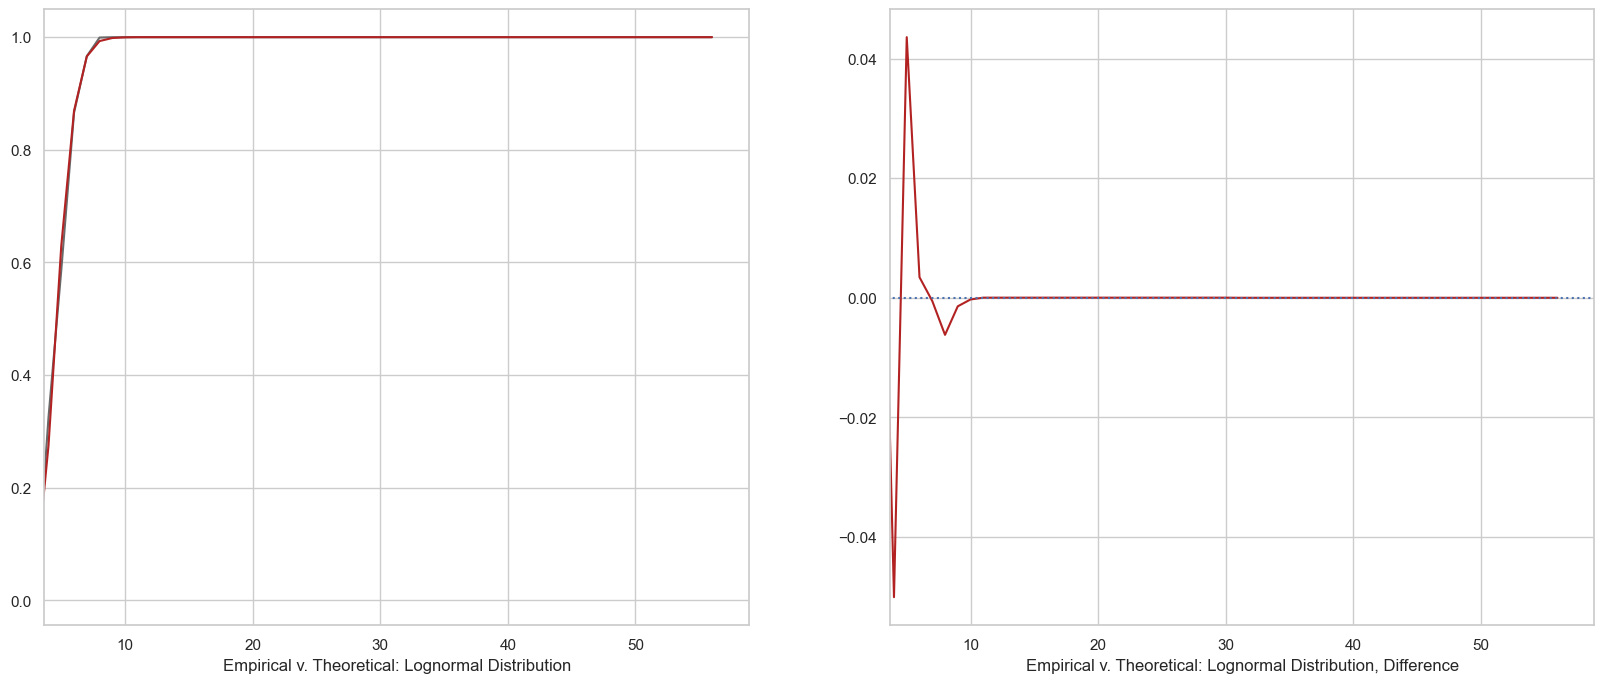

In [345]:
plot_distribution(diamonds, "y", distribution="lognormal", plot_errors=True)

This distribution appears to fit the data well with the maximum error of -0.06 percentage points. Lets now move to make predictions. What are the odds of seeing a random diamond of width greater than 8mm?

In [346]:
logged_data = np.log(diamonds["y"])
mu = logged_data.mean()
sigma = logged_data.std()
stats.lognorm.sf(8, s=sigma, scale=np.exp(mu))

0.03405493334506349

There is a 3.41% probability of observing a random diamond of width greater than 8mm. What are the odds of seeing a random diamond between 5 and 8mm?

In [347]:
stats.lognorm.cdf(8, s=sigma, scale=np.exp(mu)) - stats.lognorm.cdf(5, s=sigma, scale=np.exp(mu))

0.6965908918430384

There is a 69.66% probability of a randomly observed diamond having a width between 5 and 8mm. What is the probability of observing a diamond less than 4mm?

In [348]:
stats.lognorm.cdf(4, s=sigma, scale=np.exp(mu))

0.038134807008698944

There is a 3.81% probability of observing a random diamond and it being less than 4mm wide

## Bayesian Inference

How believeable is our predicted length of 5.7?

In [410]:
theta_est = diamonds.y.mean()
theta_est

5.735266963292547

In [412]:
posterior = bootstrap_sample(diamonds.y, np.mean)

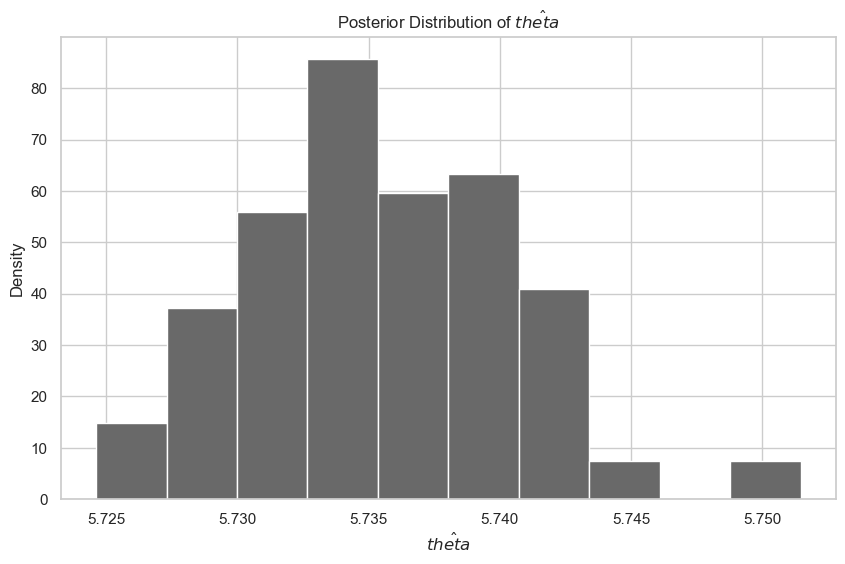

In [413]:
plot_theta(posterior)

Normally distributed like we expect. Now for our ROPE.

In [414]:
np.mean((posterior >= 5.67) & (posterior <= 5.73))

0.14

Only a 14% probability the diamond will be between 5.67 and 5.73 this is not very believable. 

<a id="depthz"></a>
## Predictive Model of Depth (z)
[^ table](#math)

We want to be able to predict depth as in, what is the depth of the next diamond we pull from the group. We want to penalize large errors more than small errors and underestimates are just as bad as overestimates. Because of this, we'll use Mean Squared Error as our loss function and we can use mean as our prediction:

In [349]:
depth_prediction = np.mean(diamonds["z"])
depth_prediction

3.5400426399703373

We predict to observe a diamond of depth 3.54mm. Now this distribution is fairly symmetric so we can use normal bounds for our error bounds. 

In [350]:
left_bound = depth_prediction - 1.96 * np.std(diamonds.z)
right_bound = depth_prediction + 1.96 * np.std(diamonds.z)
print(f"Prediction = {depth_prediction:.2f}({left_bound:.2f}, {right_bound:.2f})")

Prediction = 3.54(2.16, 4.92)


We predict a diamond of depth 3.54mm with left bound 2.16mm and right bound 4.92mm

## Depth (z)- Data Generating Story

The data generating story for depth is relatively close to the data generating story for length and width. Various environmental factors such as depth, temperature, and pressure all impacted the formation of the diamond. I believe the jewler who cut the diamond actually has more impact on the depth, but I still beleive that the factors leading to z are multiplicative and not additive. This is also due to the observed skew of the data. I believe a lognormal distribution will best model the data. 

## Depth (z)- Distributional Model

Parameters of log-transformed data: mu=1.25, sigma=0.19


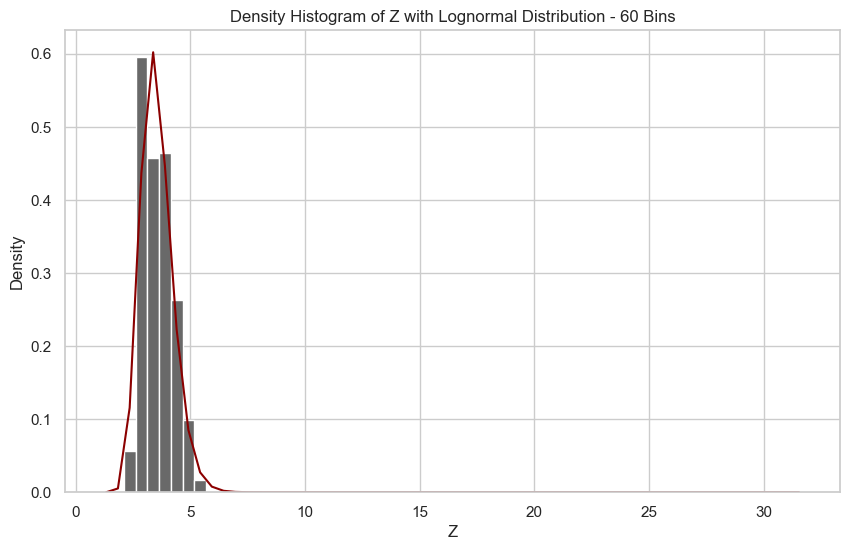

Parameters of log-transformed data: mu=1.25, sigma=0.19


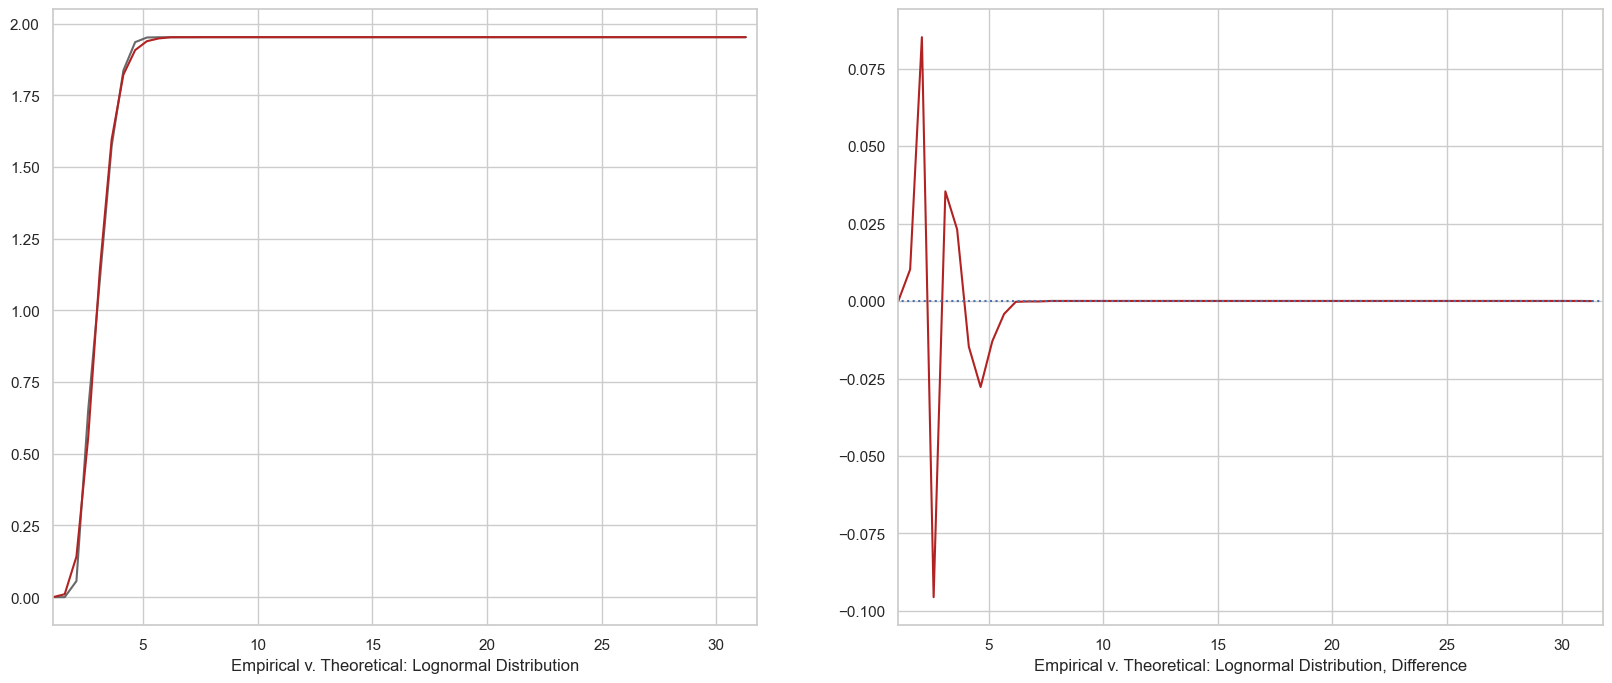

In [351]:
plot_distribution(diamonds, "z", distribution="lognormal", number_bins=60, plot_errors=True)

We see that this distribution does a good job of modeling the data with maximum error of plus or minus .08 percentage points. Now what are the odds of seeing a random diamond and it being greater than 4mm in depth?

In [352]:
logged_data = np.log(diamonds["z"])
mu = logged_data.mean()
sigma = logged_data.std()
stats.lognorm.sf(4, s=sigma, scale=np.exp(mu))

0.2336716901461503

There is a 23.37% proability of observing a random diamond and it having greater than 4mm depth. What is the probability of a diamond between 4 and 5mm in depth?

In [353]:
stats.lognorm.cdf(5, s=sigma, scale=np.exp(mu)) - stats.lognorm.cdf(4, s=sigma, scale=np.exp(mu))

0.20334528997365542

There is a 20.33% probability that a randomly observed diamond is between 4 and 5mm in depth. What is the probabilit of observing a diamond below 3mm?

In [354]:
stats.lognorm.cdf(3, s=sigma, scale=np.exp(mu))

0.2251902892014026

There is a 22.51% probability of observing a diamond below 3mm in depth.

## Bayesian Inference

We believe that a diamond depth should be between 3.55 and 3.57mm?

In [416]:
theta_est = diamonds.z.mean()
theta_est

3.5400426399703373

In [419]:
posterior = bootstrap_sample(diamonds.z, np.mean)

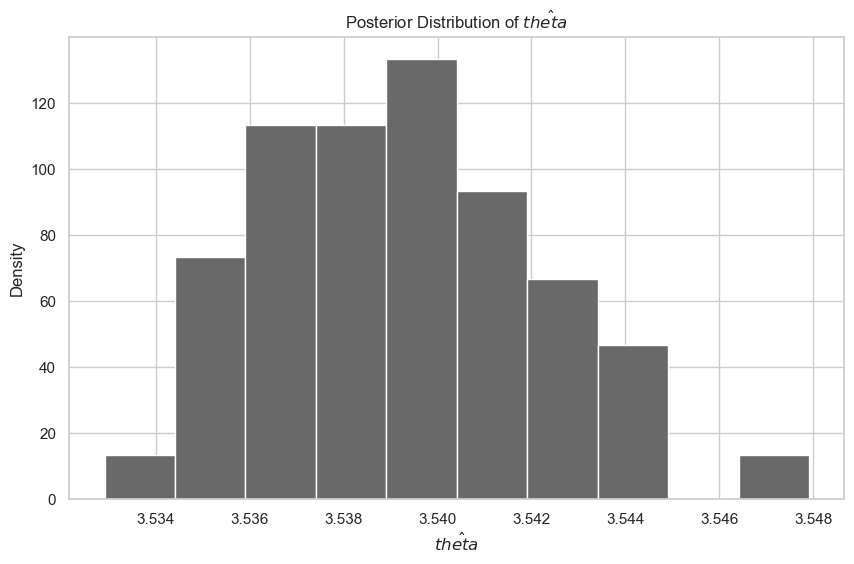

In [420]:
plot_theta(posterior)

This is normally distributed. Now our ROPE:

In [421]:
np.mean((posterior >= 3.55) & (posterior <= 3.57))

0.0

This is not believable at all with zero percent probability.

<a id="depth%"></a>
## Predictive Model of Depth (%)
[^ table](#math)

We want to be able to predict depth as in, what is the depth of the next diamond we pull from the group. We want to penalize large errors more than small errors and underestimates are just as bad as overestimates. Because of this, we'll use Mean Squared Error as our loss function and we can use mean as our prediction:

In [355]:
depth_prediction = np.mean(diamonds["depth"])
depth_prediction

61.749404894327036

We predict a diamond with depth percentage of 61.75%. Now this distributions is symmetric so we can calculate our error bounds:

In [356]:
left_bound = depth_prediction - 1.96 * np.std(diamonds.depth)
right_bound = depth_prediction + 1.96 * np.std(diamonds.depth)
print(f"Prediction = {depth_prediction:.2f}({left_bound:.2f}, {right_bound:.2f})")

Prediction = 61.75(58.94, 64.56)


We see a prediction of 61.75% with left error bound of 58.94% and right error bound of 64.56. 

## Depth (%)- Data Generating Story

The data generating story for depth percentage is different than we saw with x, y, or z. This is because depth percentage is a man made decision, and can be whatever percentage the jeweler chooses when cutting the diamond. For this reason I believe that the data generating story is additive for depth percentage, and thus this will follow a normal distribution.

## Depth (%)- Distributional Model

Freeman Diaconis:  1
Normal: mean=61.75, std=1.43


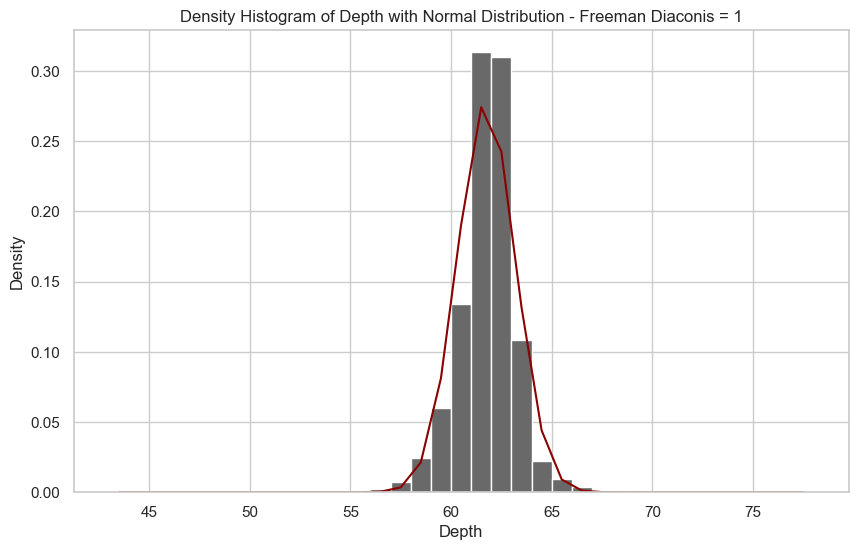

Normal: mean=61.75, std=1.43


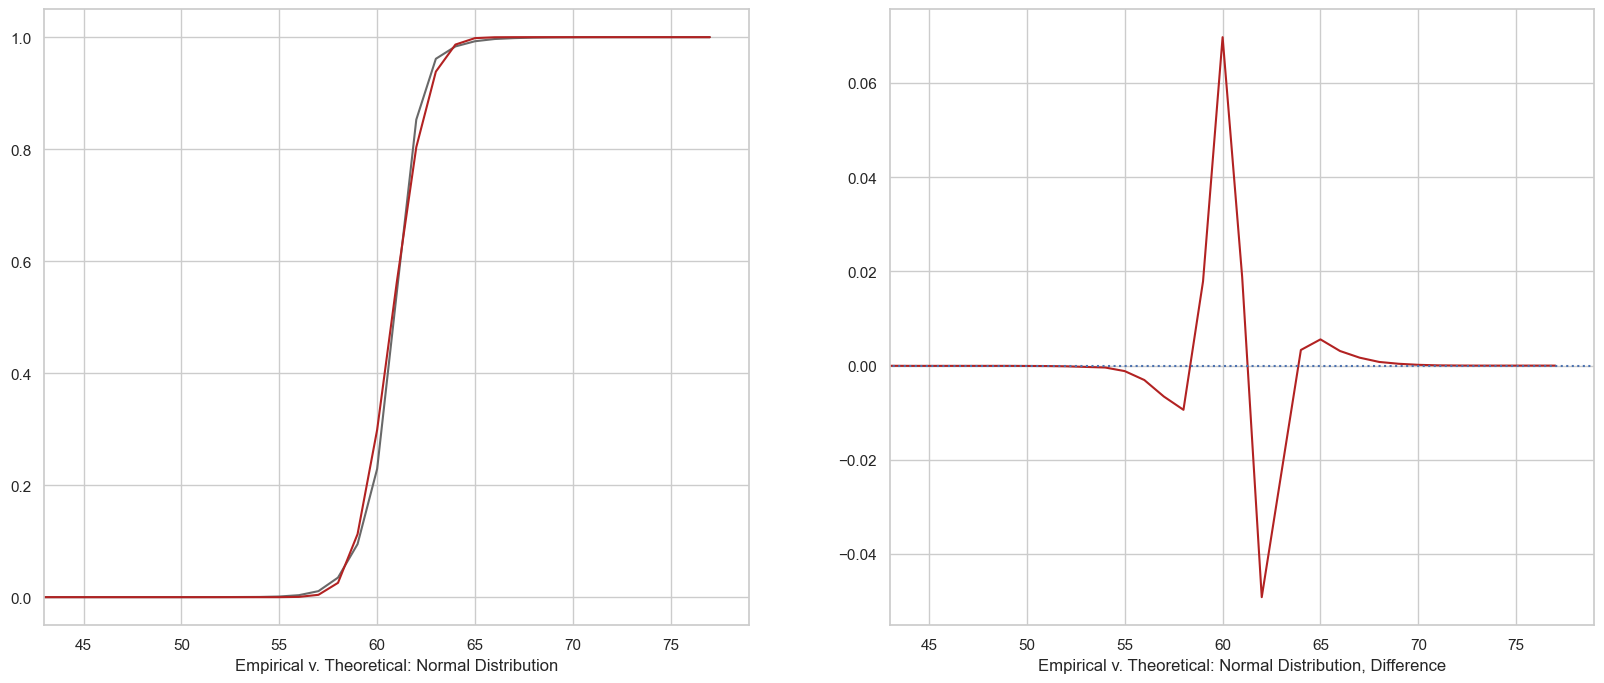

In [357]:
plot_distribution(diamonds, "depth", distribution="normal", plot_errors=True)

This does a good job of modeling our data and has a maximum error of 0.08 percentage points at the middle peak. Lets now make some predictions. What are the odds of seeing a diamond with depth greater than 63%?

In [358]:
depth_std = np.std(diamonds["depth"])
stats.norm.sf(63, depth_prediction, depth_std)

0.1913451813011957

There is a 19.13% probability of observing a random diamond with depth greater than 63%. Now what are the odds of seeing a diamond less than 60%? 

In [359]:
stats.norm.cdf(60, depth_prediction, depth_std)

0.11101784113427665

There is an 11.1% proability of observing a random diamond with depth less than 60%. What are the odds of a diamond between 61-63%?

In [360]:
stats.norm.cdf(63, depth_prediction, depth_std) - stats.norm.cdf(61, depth_prediction, depth_std)

0.5082043387776043

There is a 50.82% probability of observing a random diamond with depth between 61-63%.

<a id="tablewidth"></a>
## Predictive Model of Table Width
[^ table](#math)

We want to be able to predict table width as in, what is the table width of the next diamond we pull from the group. We want to penalize large errors more than small errors and underestimates are just as bad as overestimates. Because of this, we'll use Mean Squared Error as our loss function and we can use mean as our prediction:

In [361]:
table_prediction = np.mean(diamonds["table"])
table_prediction

57.45718390804598

We predict a table width of 57.46%. Now this distribution is relatively symmetric so we can use normal bounds for our error bounds:

In [362]:
left_bound = table_prediction - 1.96 * np.std(diamonds.table)
right_bound = table_prediction + 1.96 * np.std(diamonds.table)
print(f"Prediction = {table_prediction:.2f}({left_bound:.2f}, {right_bound:.2f})")

Prediction = 57.46(53.08, 61.84)


We predict a table width of 57.46% with left error bound 53.08 and right error bound 61.84

## Table Width- Data Generating Story

The data generating story for table width is the same as with the depth percentage. This is because table width is a man made decision, and can be whatever percentage the jeweler chooses when cutting the diamond. For this reason I believe that the data generating story is additive for table width, and thus this will follow a normal distribution.

## Table Width- Distributional Model

Freeman Diaconis:  1
Normal: mean=57.46, std=2.23


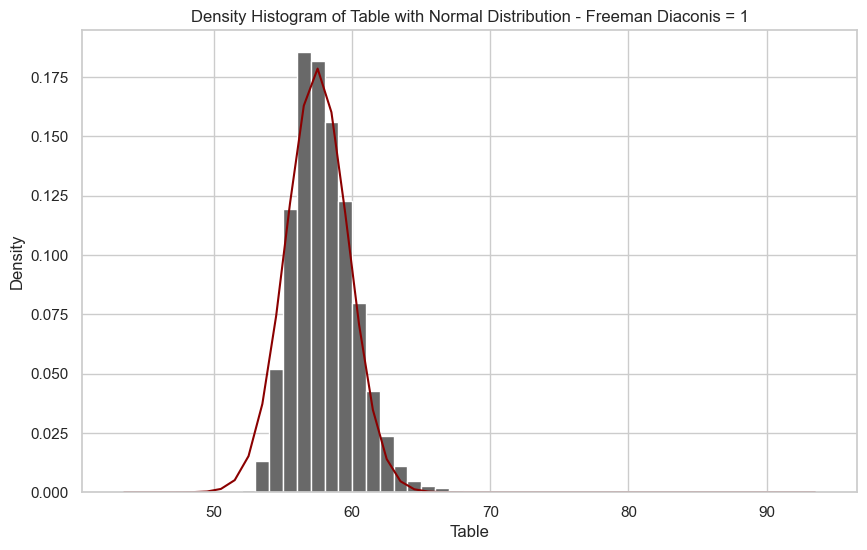

Normal: mean=57.46, std=2.23


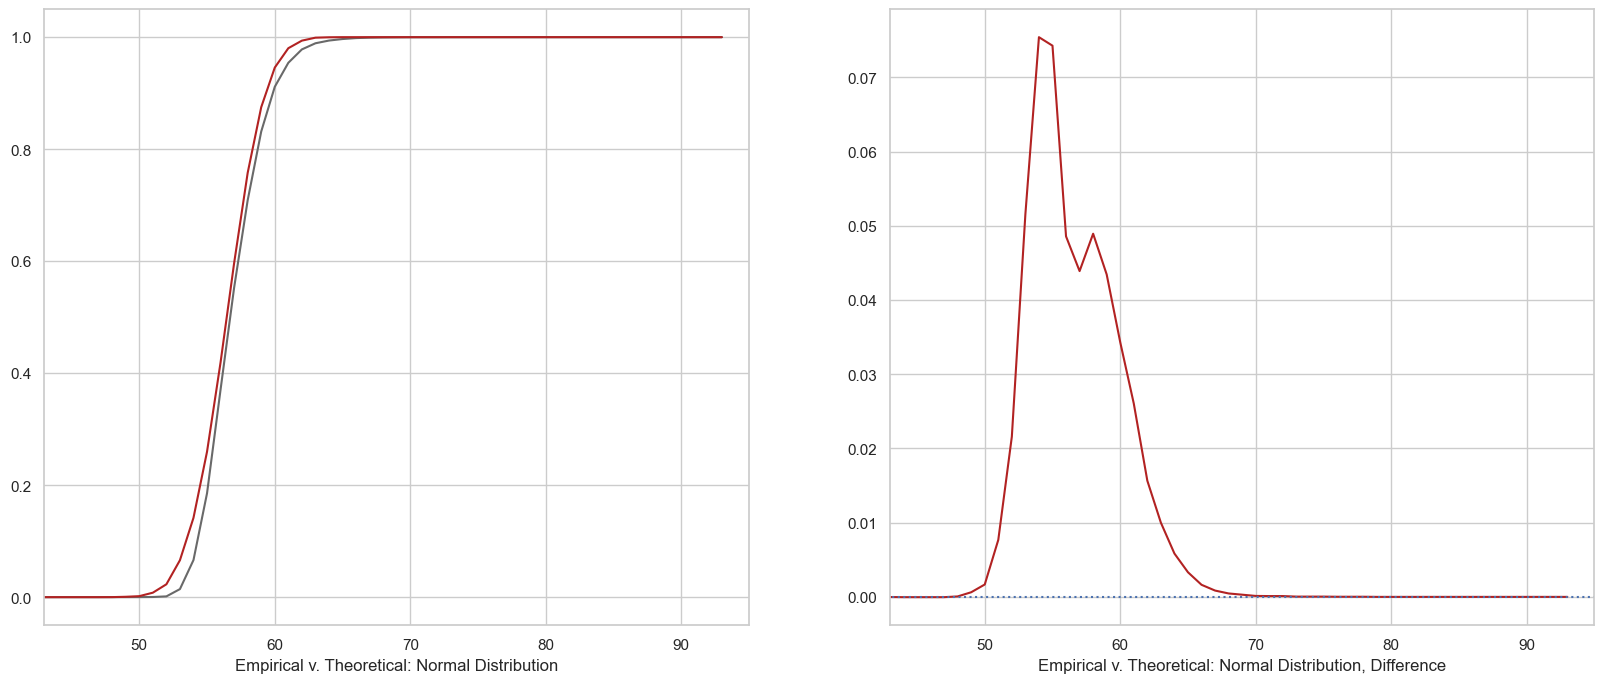

In [363]:
plot_distribution(diamonds, "table", distribution="normal", plot_errors=True)

This does a decent job of modeling our data except for a slight overestimate on the left side. This data does almost seem lognormal due to the skew, but we will stick with the normal distribution based on the data generating story and that this decently models the data with 0.07 percentage point error. Lets now make predictions. What are the odds of seeing a random diamond with over 60% table width?

In [365]:
table_std = np.std(diamonds["table"])
stats.norm.sf(60, table_prediction, table_std)

0.1275612313560589

There is a 12.76% probability of observing a random diamond with a table width greater than 60%. What is the probability of a table width between 58 and 61%?

In [366]:
stats.norm.cdf(61, table_prediction, table_std) - stats.norm.cdf(58, table_prediction, table_std) 

0.3476073184919861

There is a 34.76% probability of observing a random diamond with a table width between 58 and 61%. What is the probability of seeing a diamond with less than 57% table width?

In [367]:
stats.norm.cdf(57, table_prediction, table_std)

0.41894033857087365

There is a 41.89% probability of observing a random diamond with a table width less than 57%